# LEGO Minifigures Classification

## Data
The dataset is a collection of images of various Lego minifigures. Each image is 512x512 pixels and there are 37 classes. 

In [1]:
import os
import math
import numpy as np
import time
import matplotlib.pyplot as plt
from PIL import Image

seed = 1234
np.random.seed(seed)

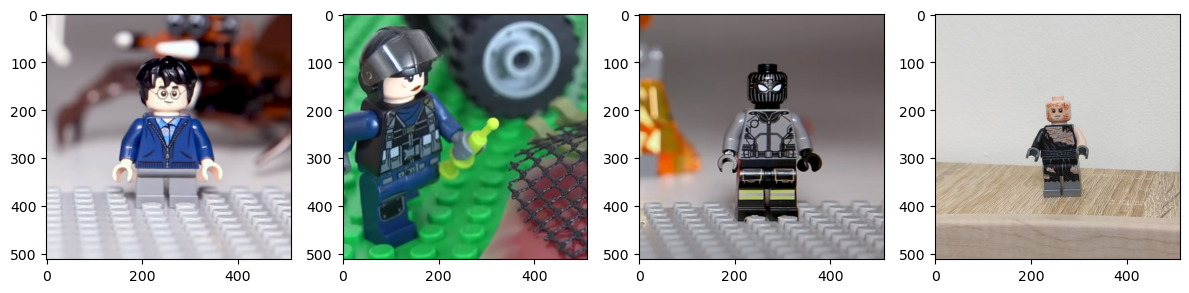

In [2]:
# Example of input images

image1 = np.asarray(Image.open('/kaggle/input/lego-minifigures-classification/harry-potter/0001/002.jpg'))
image2 = np.asarray(Image.open('/kaggle/input/lego-minifigures-classification/jurassic-world/0002/002.jpg'))
image3 = np.asarray(Image.open('/kaggle/input/lego-minifigures-classification/marvel/0007/002.jpg'))
image4 = np.asarray(Image.open('/kaggle/input/lego-minifigures-classification/star-wars/0014/002.jpg'))

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
axs[0].imshow(image1)
axs[1].imshow(image2)
axs[2].imshow(image3)
axs[3].imshow(image4)

plt.tight_layout()
plt.show()

In [3]:
# Make training and validation sets
# Training is 80% and validation is 20% of the input

import pandas as pd
import sklearn.model_selection

kaggle_path = "/kaggle/input/lego-minifigures-classification/"
index_path = kaggle_path+"index.csv"

index = pd.read_csv(index_path)
# index = index[index['class_id'] <= 10]

targets = index["class_id"].values

train, valid = sklearn.model_selection.train_test_split(index, train_size=0.8, random_state = seed, stratify=targets)
train_X = [kaggle_path+p for p in train["path"].values]
train_y = train["class_id"].values
valid_X = [kaggle_path+p for p in valid["path"].values]
valid_y = valid["class_id"].values
print("Train size:", len(train_y))
print("Validation size:", len(valid_y))

Train size: 296
Validation size: 75


In [4]:
# Labels

# metadata.csv in lego-minifigures-classification has ` instead of ' which creates an error
# metadata_path = kaggle_path+"metadata.csv"
# metadata = pd.read_csv(metadata_path)

import codecs
f = codecs.open("/kaggle/input/lego-metadata/metadata_neeraj.csv", 'r', encoding='utf-8')
metadata = f.read()
labels = metadata[3]

In [5]:
# Tests
test_path = kaggle_path+"test.csv"
test = pd.read_csv(test_path)
test_X = test["path"].values
test_y = test["class_id"].values
print("Test size:", len(test_y))

Test size: 79


## CNN

In [6]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
torch.manual_seed(seed)

class LegoDataset(Dataset):
    def __init__(self, train = False, valid = False, test = False, transform=None):
        self.data, self.labels = None, None
        if train:
            self.data = train_X
            self.labels = train_y
        if valid:
            self.data = valid_X
            self.labels = valid_y
        if test:
            self.data = test_X
            self.labels = test_y
        self.transform = transform
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = np.copy(np.asarray(Image.open(self.data[idx])))
        label = self.labels[idx]
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        return image, label

In [7]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomApply([transforms.ColorJitter(contrast=0.3)], p=0.5),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.4)], p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=(5, 5))], p=0.25),
    
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Normalize the image
])

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

trainset = LegoDataset(train = True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

validset = LegoDataset(valid = True, transform=transform)
validloader = torch.utils.data.DataLoader(validset, batch_size=1, shuffle=True, num_workers=2)

testset = LegoDataset(test = True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)

In [8]:
# Number of classes
num_classes = len(set(trainset.labels))
print("Number of classes:", num_classes)

Number of classes: 38


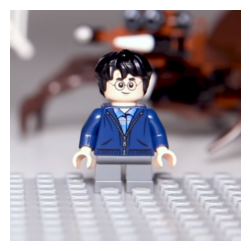

In [9]:
# Normal Tensor
image = Image.open('/kaggle/input/lego-minifigures-classification/harry-potter/0001/002.jpg')
# image = transform(image)
fig, axes = plt.subplots(1, 1, figsize=(3, 3))

# Display the augmented image
# plt.imshow(transforms.ToPILImage()(image))
# plt.imshow(np.moveaxis(image.cpu().numpy(), 0, -1))
# plt.imshow(np.transpose(image.numpy(), (1,2,0)))
plt.imshow(image)
plt.axis('off')
plt.show()

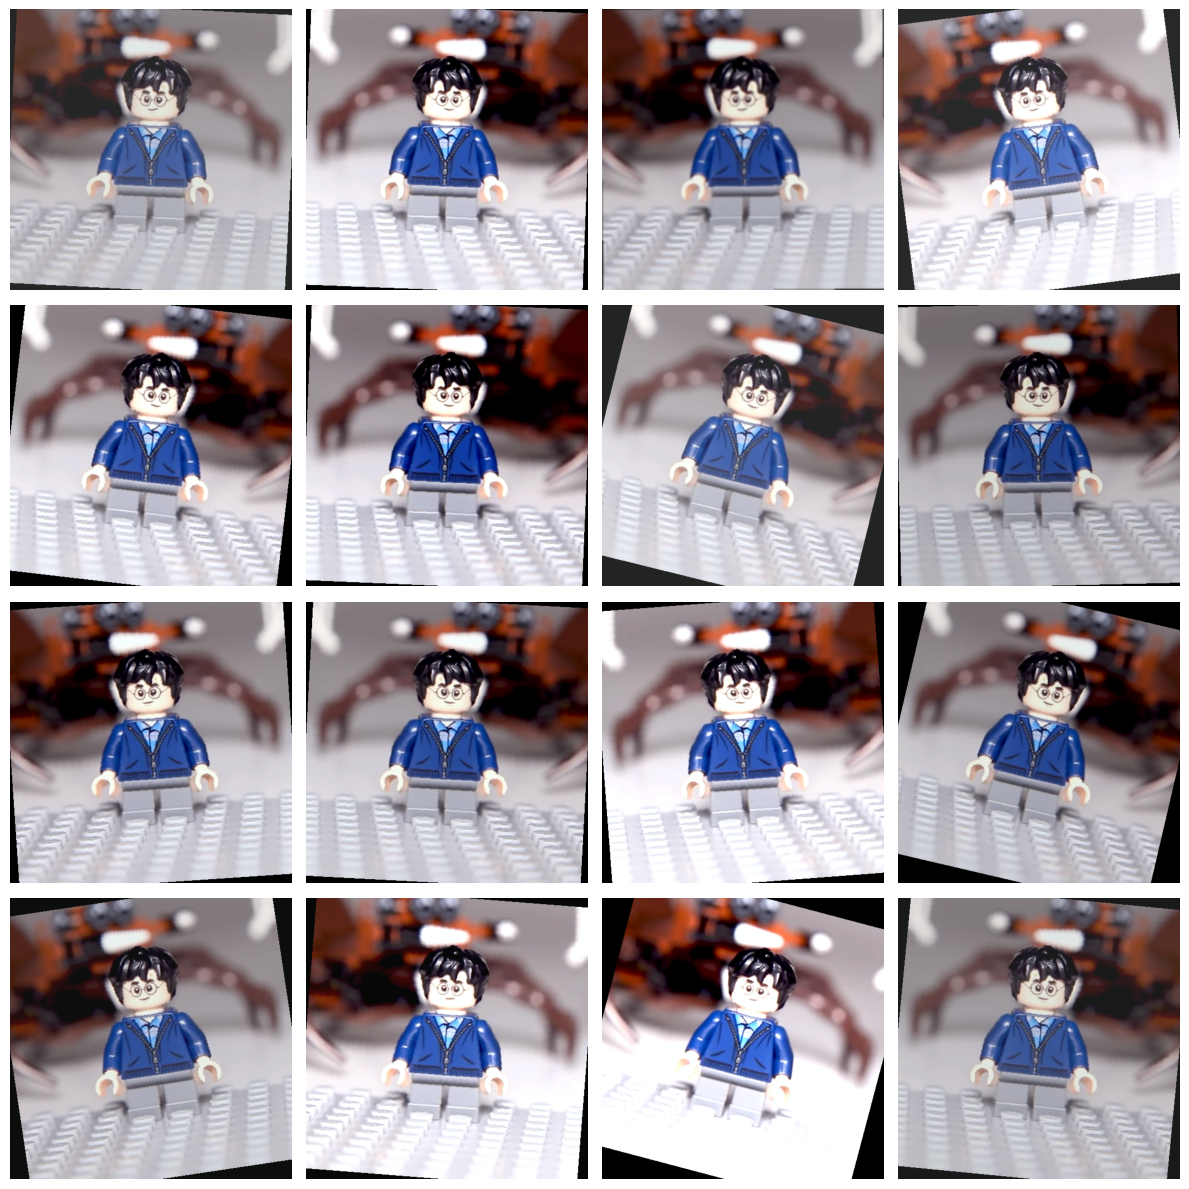

In [10]:
## Data Augmentation
image = Image.open('/kaggle/input/lego-minifigures-classification/harry-potter/0001/002.jpg')
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i in range(4):
    for j in range(4): 
        augmented_image = train_transform(image)
        augmented_image = np.moveaxis(augmented_image.cpu().numpy(), 0, -1) * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        axes[j,i].imshow(augmented_image)
        axes[j,i].axis('off')

plt.tight_layout()
plt.show()

In [11]:
from torchvision.models import mobilenet_v2
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = mobilenet_v2(pretrained=True)
# net = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
net.classifier = nn.Linear(in_features=1280, out_features=39, bias=True)
net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 88.5MB/s]


In [12]:
for epoch in range(15):
    net.train()
    running_loss = 0.0
    
    for i, data in enumerate(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if (i + 1) % 74 == 0:
            print(f"Epoch [{epoch + 1}], Step [{i + 1}/{len(trainloader)}], Loss: {running_loss / 74:.4f}")
            running_loss = 0.0

#     if epoch % 10 == 0:
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in validloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_accuracy = 100 * correct / total
    print(f"Validation Accuracy: {val_accuracy:.2f}%")

Epoch [1], Step [74/74], Loss: 3.6293
Validation Accuracy: 30.67%
Epoch [2], Step [74/74], Loss: 3.0287
Validation Accuracy: 57.33%
Epoch [3], Step [74/74], Loss: 2.5140
Validation Accuracy: 64.00%
Epoch [4], Step [74/74], Loss: 2.0695
Validation Accuracy: 80.00%
Epoch [5], Step [74/74], Loss: 1.6229
Validation Accuracy: 89.33%
Epoch [6], Step [74/74], Loss: 1.3356
Validation Accuracy: 93.33%
Epoch [7], Step [74/74], Loss: 1.0565
Validation Accuracy: 94.67%
Epoch [8], Step [74/74], Loss: 0.8507
Validation Accuracy: 93.33%
Epoch [9], Step [74/74], Loss: 0.6397
Validation Accuracy: 96.00%
Epoch [10], Step [74/74], Loss: 0.5390
Validation Accuracy: 97.33%
Epoch [11], Step [74/74], Loss: 0.4222
Validation Accuracy: 97.33%
Epoch [12], Step [74/74], Loss: 0.3379
Validation Accuracy: 97.33%
Epoch [13], Step [74/74], Loss: 0.2385
Validation Accuracy: 94.67%
Epoch [14], Step [74/74], Loss: 0.2300
Validation Accuracy: 100.00%
Epoch [15], Step [74/74], Loss: 0.1931
Validation Accuracy: 98.67%


In [13]:
# Save the model
model_path = "/kaggle/working/model.pth"
torch.save(net.state_dict(), model_path)

In [14]:
# Training set Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on training images: {100 * correct // total} %')

Accuracy of the network on training images: 100 %


In [15]:
# Validation Set Accuracy
correct = 0
total = 0
labels_all = []
pred_all = []
with torch.no_grad():
    for data in validloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        labels_all.extend(labels.cpu().numpy())
        pred_all.extend(predicted.cpu().numpy())
val_accuracy = 100 * correct / total
print(f"Top 1 Validation Accuracy: {val_accuracy:.2f}%")

Top 1 Validation Accuracy: 98.67%


In [16]:
# Top 3 Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in validloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.topk(outputs.data, 3, 1, True, True)
        top_correct = predicted.eq(labels.view(-1, 1).expand_as(predicted))
        top_correct = top_correct.sum(0).float()
        total += labels.size(0)
        correct += top_correct.sum().item()
val_accuracy = 100 * correct / total
print(f"Top 3 Validation Accuracy: {val_accuracy:.2f}%")

Top 3 Validation Accuracy: 100.00%


In [17]:
# Top 5 Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in validloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.topk(outputs.data, 5, 1, True, True)
        top_correct = predicted.eq(labels.view(-1, 1).expand_as(predicted))
        top_correct = top_correct.sum(0).float()
        total += labels.size(0)
        correct += top_correct.sum().item()
val_accuracy = 100 * correct / total
print(f"Top 5 Validation Accuracy: {val_accuracy:.2f}%")

Top 5 Validation Accuracy: 100.00%


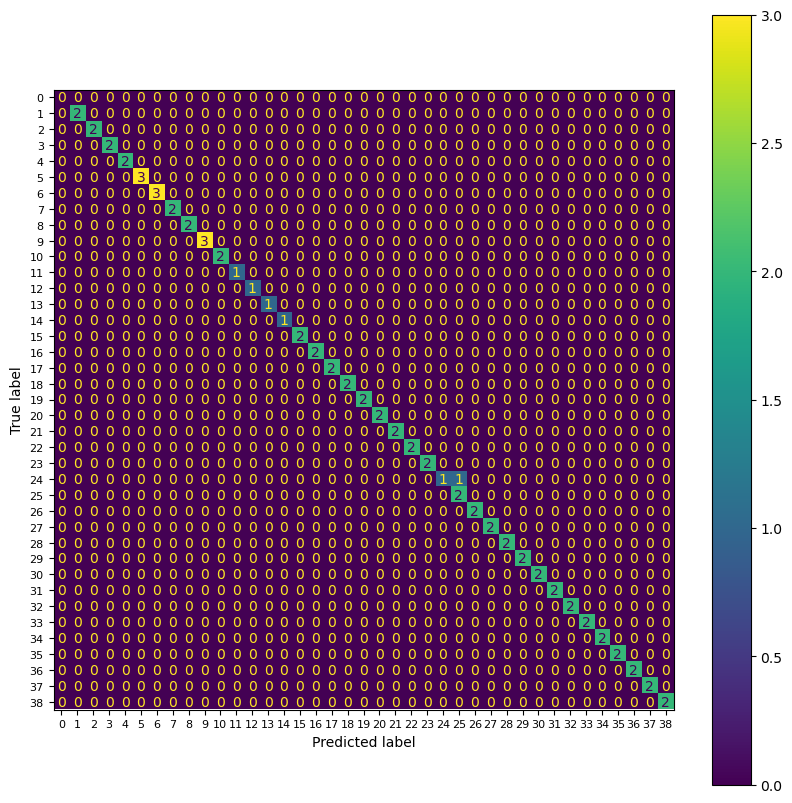

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10,10))
cfm = ConfusionMatrixDisplay.from_predictions(labels_all, pred_all, ax=ax, labels=range(39))
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()